## Using MDH Command Line to Get Data
First, we'll install the Machine Data Hub package
- type `pip install mdh` into your terminal
- type `mdh list` to view the datasets and their ID's
- type `mdh download 9 1` to download the first file of the 9th dataset

In [1]:
import pandas as pd
import numpy as np

In [1]:
f = open('CMAPSSData/readme.txt', 'r', errors='ignore')
file_contents = f.read()
print(file_contents)
f.close()

Data Set: FD001
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: ONE (HPC Degradation)

Data Set: FD002
Train trjectories: 260
Test trajectories: 259
Conditions: SIX 
Fault Modes: ONE (HPC Degradation)

Data Set: FD003
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: TWO (HPC Degradation, Fan Degradation)

Data Set: FD004
Train trjectories: 248
Test trajectories: 249
Conditions: SIX 
Fault Modes: TWO (HPC Degradation, Fan Degradation)



Experimental Scenario

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine  i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. The

## Training Data

In [1]:
train = pd.read_csv('CMAPSSData/train_FD001.txt', sep=" ", header=None)
train.columns = ['unit', 'cycle', 'op1', 'op2','op3','sm1','sm2','sm3','sm4','sm5','sm6','sm7','sm8','sm9','sm10','sm11','sm12','sm13','sm14','sm15','sm16','sm17','sm18','sm19','sm20','sm21','sm22','sm23']
train = train.iloc[:, :26]
units = train['unit']

NameError: name 'pd' is not defined

## Remaining useful life for each unit

In [2]:
RUL = pd.read_csv('CMAPSSData/RUL_FD001.txt', header=None)
RUL.columns = ['RUL']

NameError: name 'pd' is not defined

## Test Data

In [49]:
test = pd.read_csv('CMAPSSData/test_FD001.txt', sep=" ", header=None)
cols = pd.DataFrame(test.columns)
test = test.iloc[:, :26]
test.columns = ['unit', 'cycle', 'op1', 'op2','op3','sm1','sm2','sm3','sm4','sm5','sm6','sm7','sm8','sm9','sm10','sm11','sm12','sm13','sm14','sm15','sm16','sm17','sm18','sm19','sm20','sm21']

,unit,cycle,op1,op2,op3,sm1,sm2,sm3,sm4,sm5,...,sm12,sm13,sm14,sm15,sm16,sm17,sm18,sm19,sm20,sm21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


# Data Processing

In [50]:
max_life = max(train.groupby("unit")["cycle"].max())
min_life = min(train.groupby("unit")["cycle"].max())
mean_life = np.mean(train.groupby("unit")["cycle"].max())
max_life,min_life,mean_life

(362, 128, 206.31)

## Setting up X and y in training and testing data
#### Setting up Remaining Useful Life variable (y)

In [51]:
## reversing remaining useful life column so that it counts down until failure
grp = train["cycle"].groupby(train["unit"])
rul_lst = [j for i in train["unit"].unique() for j in np.array(grp.get_group(i)[::-1])] # can be used as y or target for training

#### Setting up sensor measurements (X)

In [52]:
# getting all columns except target RUL column as X
train_x = train.drop("cycle", axis=1)
test_x = test.drop("cycle", axis=1)

## Applying Principal Component Analysis

In [53]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score

In [54]:
# fitting PCA on training data, transforming training and testing data

# setting index to be unit so unit is not used as a column in PCA
train_data = train_x.set_index("unit")
test_data = test_x.set_index("unit")

# scaling the data
gen = MinMaxScaler(feature_range=(0, 1))
train_x_rescaled = gen.fit_transform(train_data)
test_x_rescaled = gen.transform(test_data)

# PCA
pca = PCA(n_components=0.95) # 95% of variance
train_data_reduced = pca.fit_transform(train_x_rescaled)
test_data_reduced = pca.transform(test_x_rescaled)

# save results as dataframes
train_df = pd.DataFrame(train_data_reduced)
test_df = pd.DataFrame(test_data_reduced)

## Making Complete Dataframe

In [55]:
# making dataframe with unit, RUL counting down instead of up, and PCA features
train_df.insert(0, "Unit", units, True)
train_df.insert(1, "RUL", rul_lst, True)
train_df.head()

,Unit,RUL,0,1,2,3,4,5,6,7,8,9,10
0,1,192,-0.410290,0.329588,-0.062926,-0.034272,0.039837,0.150101,-0.061206,-0.044378,-0.039456,0.066469,0.060335
1,1,191,-0.334079,0.245318,-0.083213,-0.020121,-0.109669,0.088208,-0.113706,-0.072674,-0.013043,0.068331,0.007763
2,1,190,-0.415501,-0.251669,-0.054831,-0.033593,0.246061,-0.010257,-0.056753,0.078662,0.145056,0.057986,0.003087
3,1,189,-0.517311,-0.005695,-0.087794,-0.027715,-0.042761,-0.058995,0.027378,0.043045,0.011939,-0.166043,-0.041628
4,1,188,-0.345767,0.164130,-0.043195,-0.036834,0.104798,-0.030646,0.082129,-0.092327,-0.030043,0.006404,-0.026205


## Splitting into Train and Validate Sets


In [56]:
import random

In [57]:
unique_units = train_df["Unit"].unique().tolist()
np.random.seed(200)
random.shuffle(unique_units)
train_units = unique_units[:80]
val_units = unique_units[80:]

In [58]:
X = train_df.iloc[:,train_df.columns != 'RUL']
y = train_df[["Unit", "RUL"]]

# splitting into train and test data based on units rather than random split
X_train = X[X['Unit'].isin(train_units)] # getting first 80 units
X_validate = X[X['Unit'].isin(val_units)] # getting last 20 units
y_train = y[y['Unit'].isin(train_units)]["RUL"] # getting first 80 units
y_validate = y[y['Unit'].isin(val_units)]["RUL"] # getting last 20 units

X_train = X_train.set_index('Unit')
X_validate = X_validate.set_index('Unit')

# Making Predictions

## Linear Regression Model

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

### Fitting the model

In [60]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_hat = reg.predict(X_validate)

### Assessing Performance

In [62]:
print('Training Cross Validation Score: ', cross_val_score(reg, X_train, y_train, cv=5))
print('Validation Cross Validation Score: ', cross_val_score(reg, X_validate, y_validate, cv=5))
print('Validation R^2: ', r2_score(y_validate, y_hat))
print('Validation MSE: ', mean_squared_error(y_validate, y_hat))

Training Cross Validation Score:  [0.65181542 0.60621829 0.56514893 0.52319301 0.51774096]
Validation Cross Validation Score:  [0.72617618 0.42561359 0.30175429 0.70016344 0.42958844]
Validation R^2:  0.5254642642582465
Validation MSE:  2437.895634893165


### Plotting Predicted vs True Values

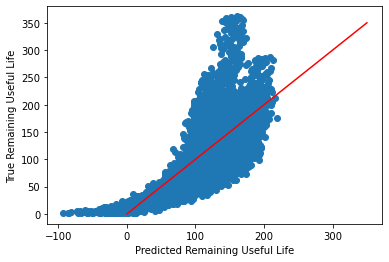

In [63]:
_ = plt.scatter(y_hat, y_validate)
_ = plt.plot([0, 350], [0, 350], "r")
_ = plt.xlabel("Predicted Remaining Useful Life")
_ = plt.ylabel("True Remaining Useful Life")

In [64]:
log_y_train = np.log(y_train)
log_y_validate = np.log(y_validate)
reg.fit(X_train, log_y_train)
y_hat = reg.predict(X_validate)
#log_y_train.isna().sum()

In [65]:
print('Training Cross Validation Score: ', cross_val_score(reg, X_train, y_train, cv=5))
print('Validation Cross Validation Score: ', cross_val_score(reg, X_validate, log_y_validate, cv=5))
print('Validation R^2: ', r2_score(log_y_validate, y_hat))
print('Validation MSE: ', mean_squared_error(log_y_validate, y_hat))

Training Cross Validation Score:  [0.65181542 0.60621829 0.56514893 0.52319301 0.51774096]
Validation Cross Validation Score:  [0.86189994 0.57916562 0.62127333 0.84606404 0.71891191]
Validation R^2:  0.7119259657778766
Validation MSE:  0.2747472045111408


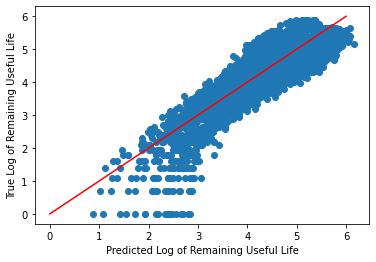

In [66]:
_ = plt.scatter(y_hat, log_y_validate)
_ = plt.plot([0, 6], [0, 6], "r")
_ = plt.xlabel("Predicted Log of Remaining Useful Life")
_ = plt.ylabel("True Log of Remaining Useful Life")

## Decision Tree Regressor
### Fitting the model

In [67]:
# trying decision tree regressor
from sklearn.tree import DecisionTreeRegressor

dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, y_train)
y_hat = dt_reg.predict(X_validate)

### Assessing Performance

In [68]:
print('Training Cross Validation Score: ', cross_val_score(dt_reg, X_train, y_train, cv=5))
print('Validation Cross Validation Score: ', cross_val_score(dt_reg, X_validate, y_validate, cv=5))
print('Validation R^2: ', r2_score(y_validate, y_hat))
print('Validation MSE: ', mean_squared_error(y_validate, y_hat))

Training Cross Validation Score:  [0.3314608  0.03284172 0.17224829 0.25248153 0.28469372]
Validation Cross Validation Score:  [ 0.21143813  0.00097633 -0.03242251  0.25507367 -0.23748143]
Validation R^2:  0.15272460204742866
Validation MSE:  4352.820743820744


### Plotting Predicted vs True Values

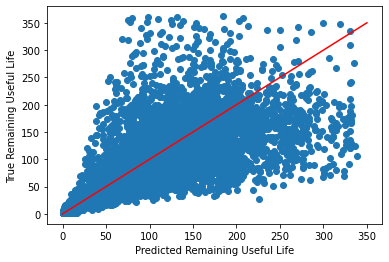

In [69]:
_ = plt.scatter(y_hat, y_validate)
_ = plt.plot([0, 350], [0, 350], "r")
_ = plt.xlabel("Predicted Remaining Useful Life")
_ = plt.ylabel("True Remaining Useful Life")

Training Cross Validation Score:  [0.77366425 0.7180512  0.73196486 0.68458347 0.67246177]
Validation Cross Validation Score:  [0.72003447 0.55813942 0.4954202  0.74433481 0.60379024]
Validation R^2:  0.680685900000316
Validation MSE:  0.3045420479245905


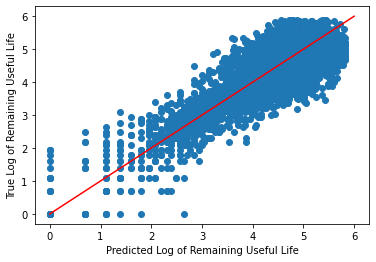

In [70]:
dt_reg.fit(X_train, log_y_train)
y_hat = dt_reg.predict(X_validate)
print('Training Cross Validation Score: ', cross_val_score(dt_reg, X_train, log_y_train, cv=5))
print('Validation Cross Validation Score: ', cross_val_score(dt_reg, X_validate, log_y_validate, cv=5))
print('Validation R^2: ', r2_score(log_y_validate, y_hat))
print('Validation MSE: ', mean_squared_error(log_y_validate, y_hat))
_ = plt.scatter(y_hat, log_y_validate)
_ = plt.plot([0, 6], [0, 6], "r")
_ = plt.xlabel("Predicted Log of Remaining Useful Life")
_ = plt.ylabel("True Log of Remaining Useful Life")

## K-Nearest Neighbors Regressor
### Fitting the Model

In [71]:
from sklearn.neighbors import KNeighborsRegressor

In [72]:
kn_reg = DecisionTreeRegressor()
kn_reg.fit(X_train, y_train)
y_hat = kn_reg.predict(X_validate)

### Assessing Performance

In [73]:
print('Training Cross Validation Score: ', cross_val_score(kn_reg, X_train, y_train, cv=5))
print('Validation Cross Validation Score: ', cross_val_score(kn_reg, X_validate, y_validate, cv=5))
print('Validation R^2: ', r2_score(y_validate, y_hat))
print('Validation MSE: ', mean_squared_error(y_validate, y_hat))

Training Cross Validation Score:  [0.33669568 0.06067125 0.19325714 0.25780171 0.29606065]
Validation Cross Validation Score:  [ 0.19072975 -0.01737705 -0.04616889  0.28963416 -0.31215523]
Validation R^2:  0.132442225711644
Validation MSE:  4457.020097020097


### Plotting Predicted vs True Values

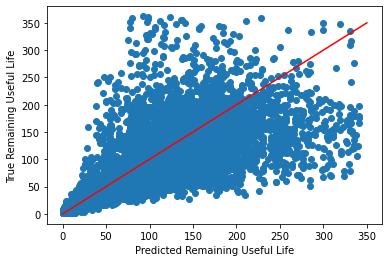

In [74]:
_ = plt.scatter(y_hat, y_validate)
_ = plt.plot([0, 350], [0, 350], "r")
_ = plt.xlabel("Predicted Remaining Useful Life")
_ = plt.ylabel("True Remaining Useful Life")

Training Cross Validation Score:  [0.77184865 0.71060796 0.73260798 0.68050613 0.67374973]
Validation Cross Validation Score:  [0.72126975 0.55465672 0.50704406 0.7478887  0.59853228]
Validation R^2:  0.6802101443785232
Validation MSE:  0.3049957942244644


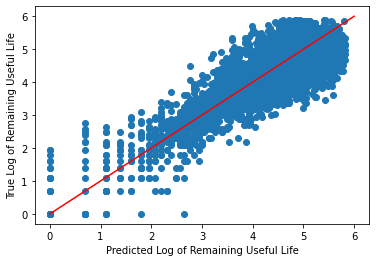

In [75]:
kn_reg.fit(X_train, log_y_train)
y_hat = kn_reg.predict(X_validate)
print('Training Cross Validation Score: ', cross_val_score(dt_reg, X_train, log_y_train, cv=5))
print('Validation Cross Validation Score: ', cross_val_score(dt_reg, X_validate, log_y_validate, cv=5))
print('Validation R^2: ', r2_score(log_y_validate, y_hat))
print('Validation MSE: ', mean_squared_error(log_y_validate, y_hat))
_ = plt.scatter(y_hat, log_y_validate)
_ = plt.plot([0, 6], [0, 6], "r")
_ = plt.xlabel("Predicted Log of Remaining Useful Life")
_ = plt.ylabel("True Log of Remaining Useful Life")

# Trying Our Model On Test Data

In [86]:
test.head()

,unit,cycle,op1,op2,op3,sm1,sm2,sm3,sm4,sm5,...,sm12,sm13,sm14,sm15,sm16,sm17,sm18,sm19,sm20,sm21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [77]:
# taking log of y values
y_test = np.log(RUL)

In [78]:
#test_grp = train["cycle"].groupby(test["unit"])
#test_rul_lst = [j for i in test["unit"].unique() for j in np.array(test_grp.get_group(i)[::-1])]


In [90]:
# Test Data with PCA (fit on training data) applied 
test_df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.330564,-0.253382,-0.078112,-0.013062,-0.131955,-0.198630,-0.038849,0.006940,0.035415,-0.066983,-0.067194
1,-0.513213,0.246559,-0.014673,-0.054873,0.153201,0.153750,-0.026192,0.019489,-0.104102,-0.089667,-0.003584
2,-0.317142,-0.086241,-0.040033,-0.030177,-0.017871,-0.034501,-0.026490,-0.076152,-0.103111,0.122481,-0.006456
3,-0.375733,-0.005388,-0.104104,-0.009910,-0.242595,-0.052442,-0.008140,0.036093,0.044614,-0.020611,0.144782
4,-0.467751,-0.005154,-0.085730,-0.023812,-0.082489,-0.073847,-0.099955,0.017419,0.118853,0.026453,0.055897


In [80]:
# predict remaining useful life
y_hat_test = reg.predict(test_df)

#make predictions into a dataframe
y_hat_test = pd.DataFrame(y_hat_test)

# add unit column back in so that we know which predictions go with which unit
y_hat_test.insert(0, "unit", test["unit"])

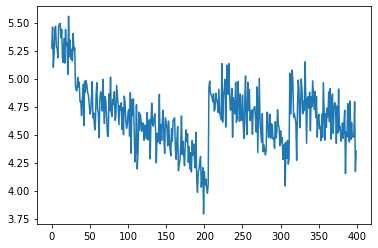

In [81]:
_ = plt.plot(y_hat_test[0][0:400])

In [82]:
rul_pred = []

# loop through all units
for each in range(1,101):
    # get data for one unit at a time
    unit_data = y_hat_test[y_hat_test["unit"] == each]
    
    # get last prediction for that unit and add it to the list of predictions
    rul_pred.append(unit_data.tail(1).iloc[0][0])
rul_pred = pd.DataFrame(rul_pred)

In [83]:
rul_pred.head()

,0
0,5.276372
1,4.661821
2,4.047469
3,4.276243
4,4.430838


In [84]:
print('Training Cross Validation Score: ', cross_val_score(reg, rul_pred, y_test, cv=5))
print('Validation Cross Validation Score: ', cross_val_score(reg, rul_pred, y_test, cv=5))
print('Validation R^2: ', r2_score(y_test, rul_pred))
print('Validation MSE: ', mean_squared_error(y_test, rul_pred))

Training Cross Validation Score:  [0.47533422 0.82207707 0.66695714 0.80961257 0.80561609]
Validation Cross Validation Score:  [0.47533422 0.82207707 0.66695714 0.80961257 0.80561609]
Validation R^2:  0.7423429266648431
Validation MSE:  0.18018159916559606


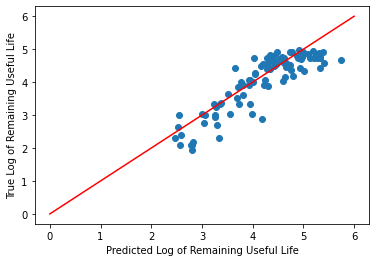

In [85]:
_ = plt.scatter(rul_pred, y_test)
_ = plt.plot([0, 6], [0, 6], "r")
_ = plt.xlabel("Predicted Log of Remaining Useful Life")
_ = plt.ylabel("True Log of Remaining Useful Life")